In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [210]:
df_all = pd.read_excel("sleep75.xls")
df_all

,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
0,32,0,1,0.000000,0.000000,12,0,0,1,3529,...,0,3438,0,3438,0,14,0,13,7.070004,1024
1,31,0,2,0.000000,0.000000,14,9500,1,1,2140,...,0,5020,0,5020,0,11,0,0,1.429999,961
2,44,0,3,0.000000,0.000000,17,42500,1,1,4595,...,1,2815,0,2815,0,21,0,0,20.53,1936
3,30,0,4,0.000000,0.000000,12,42500,1,1,3211,...,1,3786,0,3786,0,12,0,12,9.619998,900
4,64,0,5,0.000000,0.000000,14,2500,1,1,4052,...,1,2580,0,2580,0,44,0,33,2.75,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,45,0,702,0.182331,0.030075,12,5500,1,0,5069,...,1,2026,0,2026,0,27,0,18,.,2025
702,34,0,703,0.182331,0.030075,10,2500,0,0,5885,...,0,675,1,465,210,18,0,4,.,1156
703,37,0,704,0.182331,0.030075,12,3500,1,0,4719,...,1,1851,0,1851,0,19,0,17,.,1369
704,54,0,705,0.182331,0.030075,17,32500,1,0,5149,...,1,1961,1,1481,480,31,0,22,.,2916


## Data Cleansing
> Type Casting

In [211]:
type_mapping = {
    'age': np.int64,
    'black': np.int64,
    'case': np.int64,
    'clerical': np.int64,
    'construction': np.int64,
    'education': np.int64,
    'earnings': np.int64,
    'good_health': np.int64,
    'labor_force': np.int64,
    'leisure_1': np.int64,
    'leisure_2': np.int64,
    'leisure_3': np.int64,
    'smsa': np.int64,
    'lhrwage': np.float64,
    'othinc': np.float64,
    'male': np.int64,
    'married': np.int64,
    'protestant': np.int64,
    'relax_all': np.int64,
    'self_employed': np.int64,
    'sleep': np.int64,
    'sleep_naps': np.int64,
    'south': np.int64,
    'spouse_pay': np.int64,
    'spouse_work': np.int64,
    'total_work': np.int64,
    'union': np.int64,
    'work_main': np.int64,
    'work_scnd': np.int64,
    'expertise': np.int64,
    'young_kid': np.int64,
    'years_married': np.int64,
    'hour_wage': np.float64,
    'age_squared': np.int64
}

In [212]:
assert not set(type_mapping.keys()).difference(set(df_all.columns)), "Not all columns are handled"

In [213]:
def can_cast(value: object, type_: type) -> bool:
    try:
        type_(value)
        if (issubclass(type_, int) or issubclass(type_, np.integer)) and not np.float64(value).is_integer():
            return False  # Prevent casting float-like strings to int
        return True
    except ValueError:
        return False

> converting invalid data in cells to NaNs

In [214]:
for column in df_all.columns:
    df_all[column] = df_all[column] \
    .apply(lambda x: x if can_cast(x, type_mapping[column]) else np.nan) \

df_all = df_all.astype({k: v.__name__.title() for k, v in type_mapping.items()})

In [215]:
df_all[["leisure_2", "leisure_3", "sleep_naps", "total_work", "sleep"]]

,leisure_2,leisure_3,sleep_naps,total_work,sleep
0,3479,3479,3163,3438,3113
1,2140,2140,2920,5020,2920
2,4505,4227,2760,2815,2670
3,3211,3211,3083,3786,3083
4,4007,4007,3493,2580,3448
...,...,...,...,...,...
701,4669,4644,3385,2026,2985
702,5870,5870,3535,675,3520
703,4719,4584,3510,1851,3510
704,5119,5031,3000,1961,2970


In [216]:
# columns = df_all.columns[:9].tolist() + df_all.columns[13:18].tolist() + [df_all.columns[21]] + df_all.columns[23:].tolist()
# print(columns)
df = df_all#[columns]

In [217]:
df.dtypes

age                Int64
black              Int64
case               Int64
clerical           Int64
construction       Int64
education          Int64
earnings           Int64
good_health        Int64
labor_force        Int64
leisure_1          Int64
leisure_2          Int64
leisure_3          Int64
smsa               Int64
lhrwage          Float64
othinc           Float64
male               Int64
married            Int64
protestant         Int64
relax_all          Int64
self_employed      Int64
sleep              Int64
sleep_naps         Int64
south              Int64
spouse_pay         Int64
spouse_work        Int64
total_work         Int64
union              Int64
work_main          Int64
work_scnd          Int64
expertise          Int64
young_kid          Int64
years_married      Int64
hour_wage        Float64
age_squared        Int64
dtype: object

### Missingness
About 25% percent of data in columns `['Construction', 'Clerical', 'lhrwage', 'hour_wage']` are missing

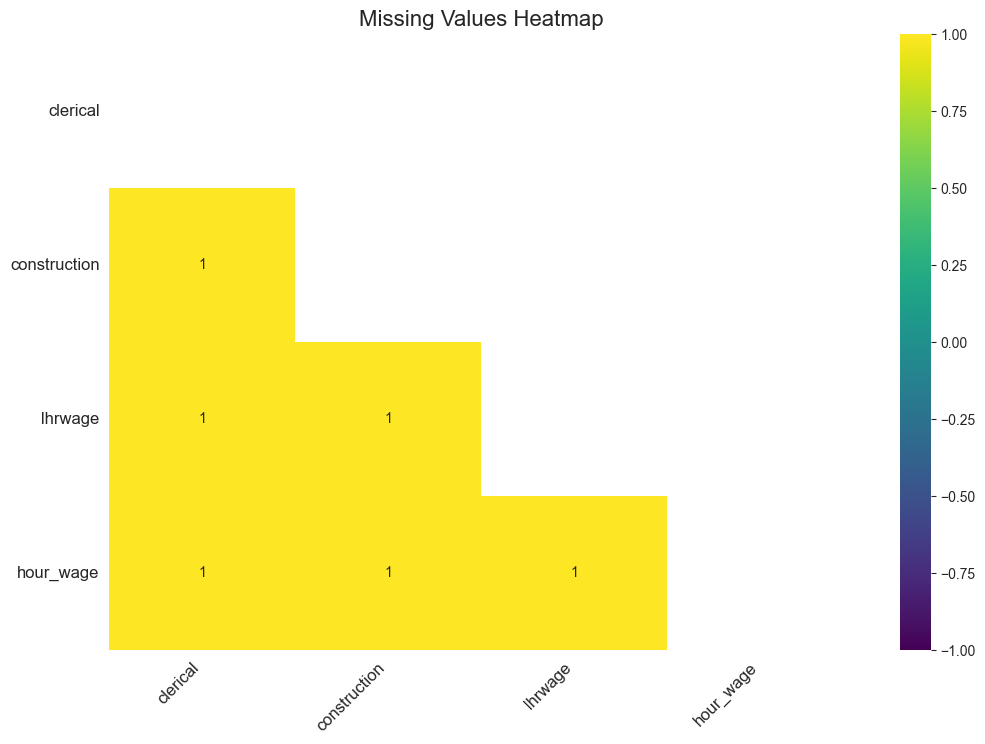

<Axes: >

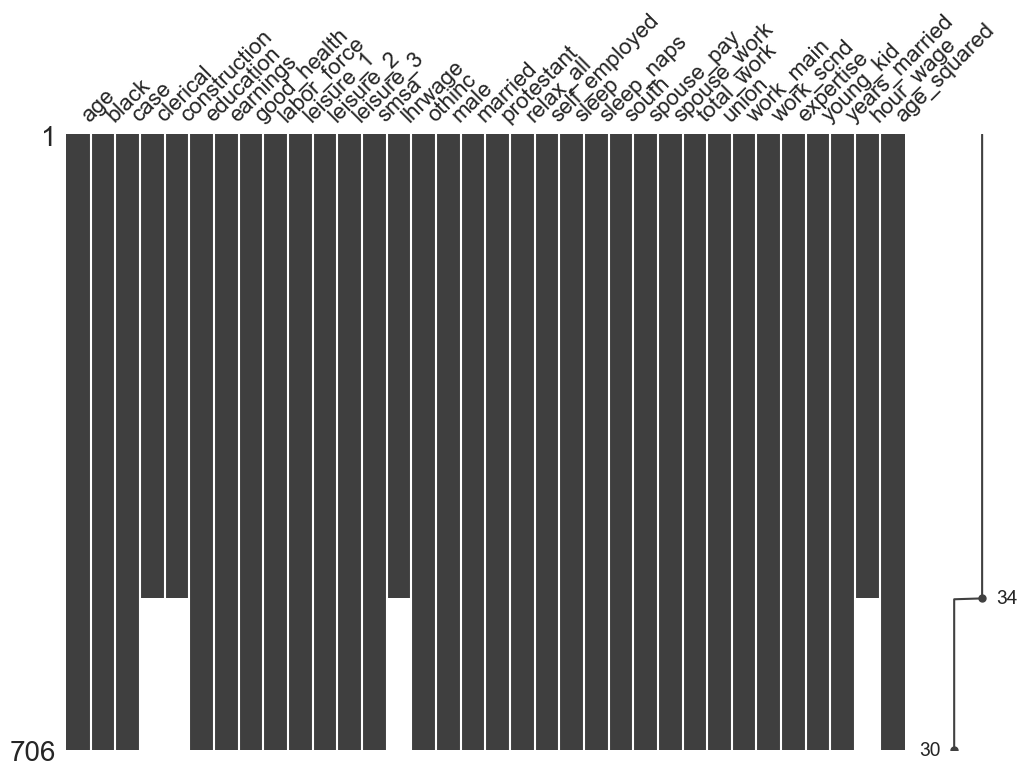

In [218]:
import missingno as msno

msno.heatmap(df, figsize=(12, 8), fontsize=12, cmap='viridis')
plt.title("Missing Values Heatmap", fontsize=16)
plt.show()

msno.matrix(df, figsize=(12, 8))

<Axes: >

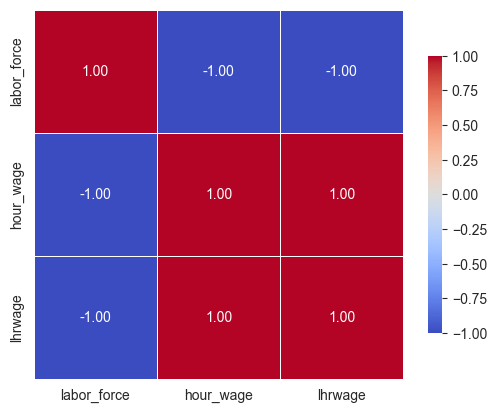

In [219]:
df_nan = df.copy()
float64_cols = df_nan.select_dtypes(include=['float64'])
columns_with_na = float64_cols.columns[float64_cols.isna().any()].tolist()
df_nan[columns_with_na] = df_nan[columns_with_na].isna()
sns.heatmap(df_nan[["labor_force", "hour_wage", "lhrwage"]].corr(),
            annot=True,         # Show correlation coefficients
            fmt=".2f",          # Format for coefficients
            cmap="coolwarm",    # Color palette
            vmin=-1, vmax=1,    # Fixed scale
            square=True,        # Make cells square
            linewidths=0.5,     # Line width between cells
            cbar_kws={"shrink": .75})  # Colorbar shrink

> Hour wage is missing for people who are not in the labor force, to continue we assume as if they were in labor force \
> And assign a wage based on the average wage of people in similar groups (buckets) \
> Additionally we add clerical and construction work to data based on the current distribution

### Imputation
> Non-binary data is imputed based on 'educated' mean, mean of a group to which that person most likely belongs to
> Binary data is imputed by chance, base on how the data wos distributed before imputation

In [220]:
non_working = df["labor_force"] == 0
df.loc[non_working, "clerical"] = pd.NA
df.loc[non_working, "construction"] = pd.NA
df.loc[non_working, "hour_wage"] = np.nan
df.loc[non_working, "lhrwage"] = np.nan

df.loc[df["total_work"] == 0, ['hour_wage', 'lhrwage']] = 0
df

,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
0,32,0,1,0,0,12,0,0,1,3529,...,0,3438,0,3438,0,14,0,13,7.070004,1024
1,31,0,2,0,0,14,9500,1,1,2140,...,0,5020,0,5020,0,11,0,0,1.429999,961
2,44,0,3,0,0,17,42500,1,1,4595,...,1,2815,0,2815,0,21,0,0,20.53,1936
3,30,0,4,0,0,12,42500,1,1,3211,...,1,3786,0,3786,0,12,0,12,9.619998,900
4,64,0,5,0,0,14,2500,1,1,4052,...,1,2580,0,2580,0,44,0,33,2.75,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,45,0,702,<NA>,<NA>,12,5500,1,0,5069,...,1,2026,0,2026,0,27,0,18,<NA>,2025
702,34,0,703,<NA>,<NA>,10,2500,0,0,5885,...,0,675,1,465,210,18,0,4,<NA>,1156
703,37,0,704,<NA>,<NA>,12,3500,1,0,4719,...,1,1851,0,1851,0,19,0,17,<NA>,1369
704,54,0,705,<NA>,<NA>,17,32500,1,0,5149,...,1,1961,1,1481,480,31,0,22,<NA>,2916


C:\Users\Mateusz\AppData\Local\Temp\ipykernel_52728\1685747634.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


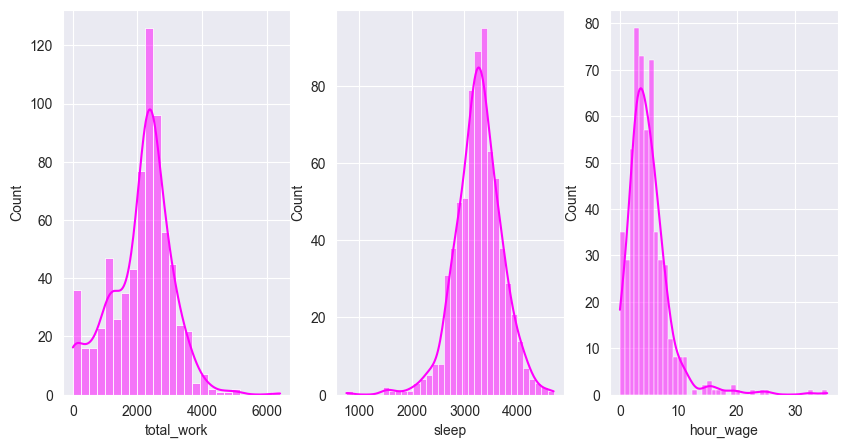

In [221]:
important_columns = ["total_work", "sleep", "hour_wage"]
fig, ax = plt.subplots(1,len(important_columns), figsize=(10, 5))
for i, col in enumerate(important_columns):
    sns.histplot(df[col], ax=ax[i], kde=True, color="magenta")
fig.show()


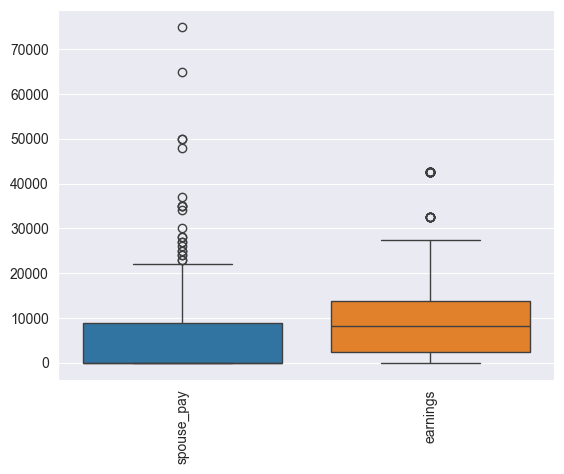

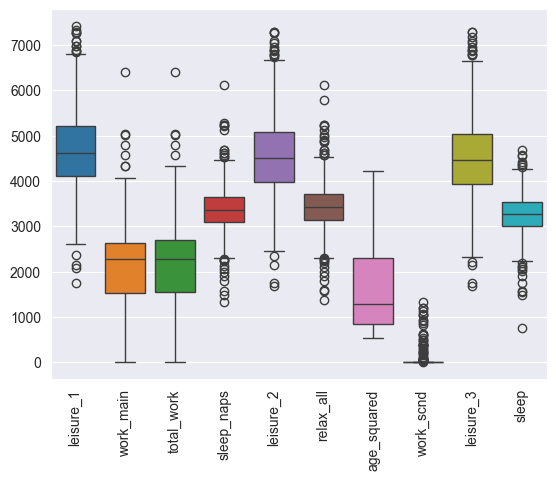

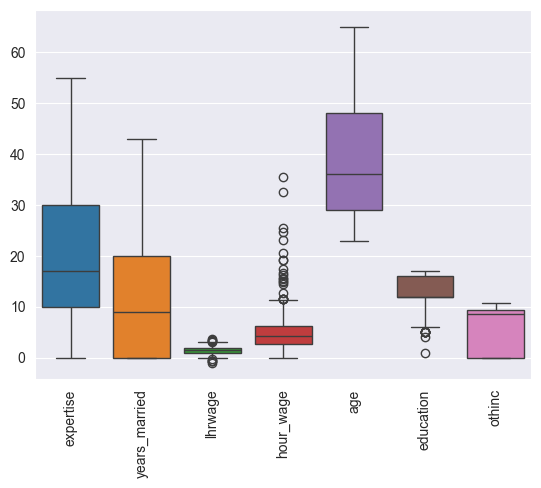

In [222]:
big_columns = {"earnings", "spouse_pay"}
binary_columns = set(df.columns[df.nunique() == 2])
low_columns = set(df.columns[df.max() <= 200]) - binary_columns

def show_boxplots(df: pd.DataFrame):
    sns.boxplot(df[list(big_columns)])
    plt.xticks(rotation=90)
    plt.show()

    sns.boxplot(df[list(set(df.columns) - big_columns - {"case"} - binary_columns - low_columns)])
    plt.xticks(rotation=90)
    plt.show()

    sns.boxplot(df[list(low_columns)])
    plt.xticks(rotation=90)
    plt.show()

show_boxplots(df)


### Outliers

In [223]:
possible_outliers = ["total_work", "work_main", "spouse_pay", "sleep"]
# quantile = df[possible_outliers].quantile(0.98)
float64_cols = list(set(df.columns) - binary_columns - {"hour_wage", "lhrwage"})
print(float64_cols)

quantiles = { col: np.percentile(df[col], [0.05, 0.95]) for col in float64_cols }

inconsistent_check = (
    (df['earnings'] == 0) &
    (df['total_work'] > 0) &
    (df['hour_wage'] > 0) &
    (~df['hour_wage'].isna())
)

print(df.dtypes)

df.loc[inconsistent_check, 'earnings'] = \
    ((df.loc[inconsistent_check, 'total_work'] / 60) * \
    df.loc[inconsistent_check, 'hour_wage'] * 52).astype("Int64")

# q5, q95 = df[].quantile([0.05, 0.95])

# df_normalized = df[(df[possible_outliers] <= quantile).all(axis=1)]

df_normalized = df
df_normalized

['leisure_1', 'years_married', 'work_main', 'sleep_naps', 'age', 'othinc', 'relax_all', 'age_squared', 'work_scnd', 'sleep', 'spouse_pay', 'expertise', 'case', 'earnings', 'total_work', 'leisure_2', 'education', 'leisure_3']
age                Int64
black              Int64
case               Int64
clerical           Int64
construction       Int64
education          Int64
earnings           Int64
good_health        Int64
labor_force        Int64
leisure_1          Int64
leisure_2          Int64
leisure_3          Int64
smsa               Int64
lhrwage          Float64
othinc           Float64
male               Int64
married            Int64
protestant         Int64
relax_all          Int64
self_employed      Int64
sleep              Int64
sleep_naps         Int64
south              Int64
spouse_pay         Int64
spouse_work        Int64
total_work         Int64
union              Int64
work_main          Int64
work_scnd          Int64
expertise          Int64
young_kid          Int64


,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
0,32,0,1,0,0,12,21065,0,1,3529,...,0,3438,0,3438,0,14,0,13,7.070004,1024
1,31,0,2,0,0,14,9500,1,1,2140,...,0,5020,0,5020,0,11,0,0,1.429999,961
2,44,0,3,0,0,17,42500,1,1,4595,...,1,2815,0,2815,0,21,0,0,20.53,1936
3,30,0,4,0,0,12,42500,1,1,3211,...,1,3786,0,3786,0,12,0,12,9.619998,900
4,64,0,5,0,0,14,2500,1,1,4052,...,1,2580,0,2580,0,44,0,33,2.75,4096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,45,0,702,<NA>,<NA>,12,5500,1,0,5069,...,1,2026,0,2026,0,27,0,18,<NA>,2025
702,34,0,703,<NA>,<NA>,10,2500,0,0,5885,...,0,675,1,465,210,18,0,4,<NA>,1156
703,37,0,704,<NA>,<NA>,12,3500,1,0,4719,...,1,1851,0,1851,0,19,0,17,<NA>,1369
704,54,0,705,<NA>,<NA>,17,32500,1,0,5149,...,1,1961,1,1481,480,31,0,22,<NA>,2916


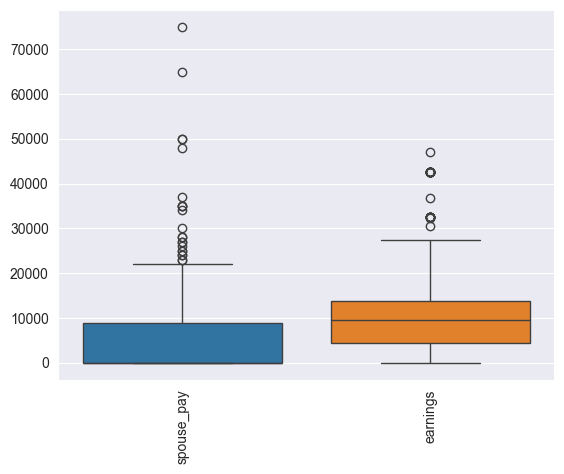

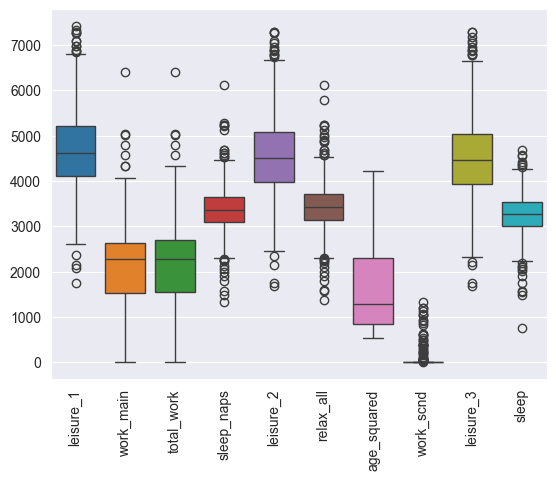

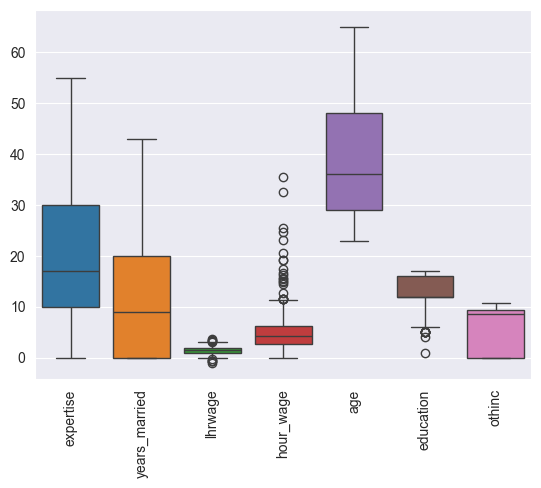

In [224]:
show_boxplots(df_normalized)

### Some Data Visualization

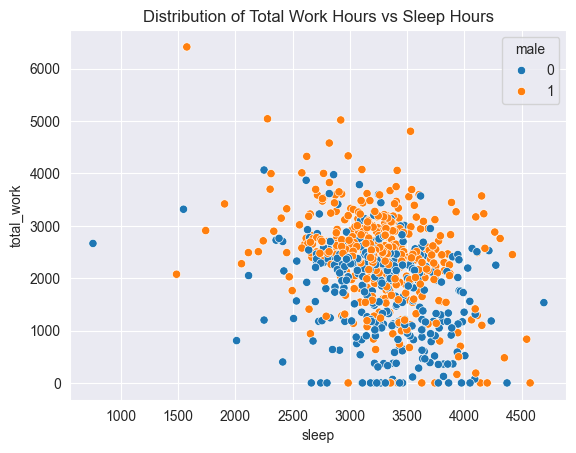

In [225]:
sns.scatterplot(df_normalized, x="sleep", y="total_work", hue="male")
plt.title("Distribution of Total Work Hours vs Sleep Hours")
plt.show()

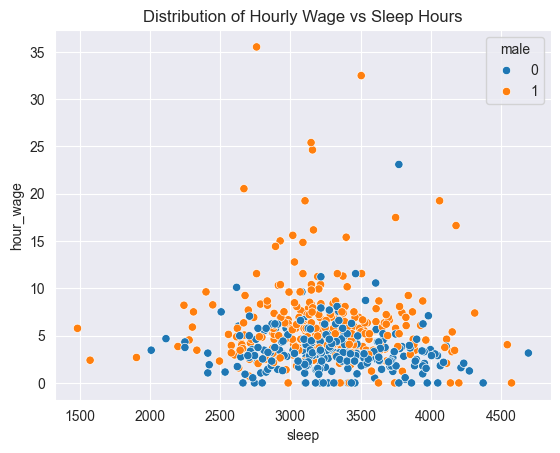

In [226]:
sns.scatterplot(df_normalized, x="sleep", y="hour_wage", hue="male")
plt.title("Distribution of Hourly Wage vs Sleep Hours")
plt.show()

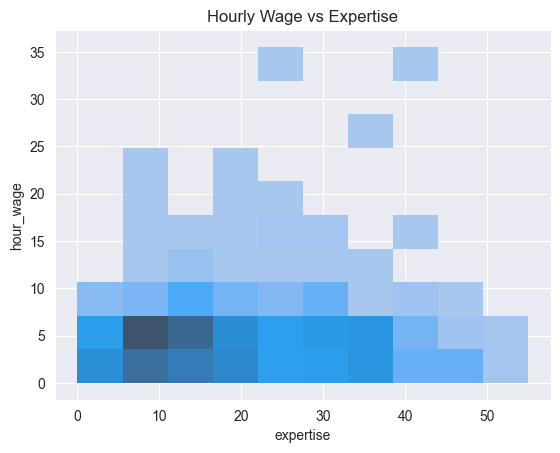

In [227]:
sns.histplot(df_normalized, x="expertise", y="hour_wage", bins=10)
plt.title("Hourly Wage vs Expertise")
plt.show()

In [228]:
df_normalized.describe()

,age,black,case,clerical,construction,education,earnings,good_health,labor_force,leisure_1,...,spouse_work,total_work,union,work_main,work_scnd,expertise,young_kid,years_married,hour_wage,age_squared
count,706.0,706.0,706.0,532.0,532.0,706.0,706.0,706.0,706.0,706.0,...,706.0,706.0,706.0,706.0,706.0,706.0,706.0,706.0,543.0,706.0
mean,38.815864,0.049575,353.5,0.182331,0.030075,12.780453,10731.267705,0.890935,0.753541,4690.723796,...,0.48017,2122.92068,0.21813,2093.252125,29.668555,20.035411,0.128895,11.769122,4.857385,1635.144476
std,11.342637,0.217219,203.948932,0.38648,0.170955,2.784702,9250.393112,0.311942,0.431254,908.049561,...,0.499961,947.470123,0.413269,945.301457,148.834262,12.37752,0.335321,11.591227,3.821039,950.102976
min,23.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1745.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529.0
25%,29.0,0.0,177.25,0.0,0.0,12.0,4500.0,1.0,1.0,4109.75,...,0.0,1553.5,0.0,1538.0,0.0,10.0,0.0,0.0,2.695,841.0
50%,36.0,0.0,353.5,0.0,0.0,12.0,9500.0,1.0,1.0,4620.0,...,0.0,2288.0,0.0,2275.0,0.0,17.0,0.0,9.0,4.16,1296.0
75%,48.0,0.0,529.75,0.0,0.0,16.0,13750.0,1.0,1.0,5203.75,...,1.0,2691.75,0.0,2635.5,0.0,30.0,0.0,20.0,6.14,2304.0
max,65.0,1.0,706.0,1.0,1.0,17.0,46935.0,1.0,1.0,7417.0,...,1.0,6415.0,1.0,6415.0,1337.0,55.0,1.0,43.0,35.50999,4225.0


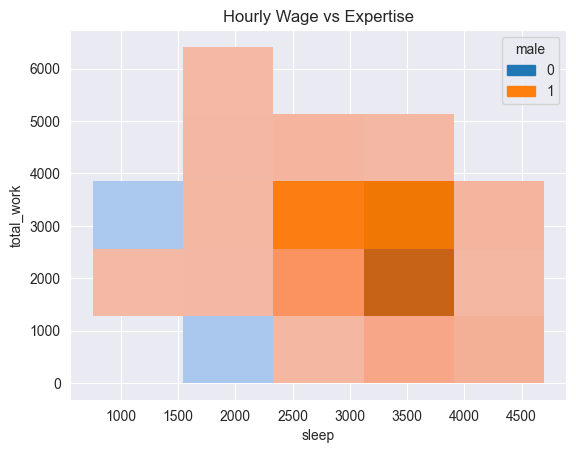

In [229]:
sns.histplot(
    df_normalized,
    x="sleep",
    y="total_work",
    hue="male",
    stat="density",
    bins=5,
)
plt.title("Hourly Wage vs Expertise")
plt.show()

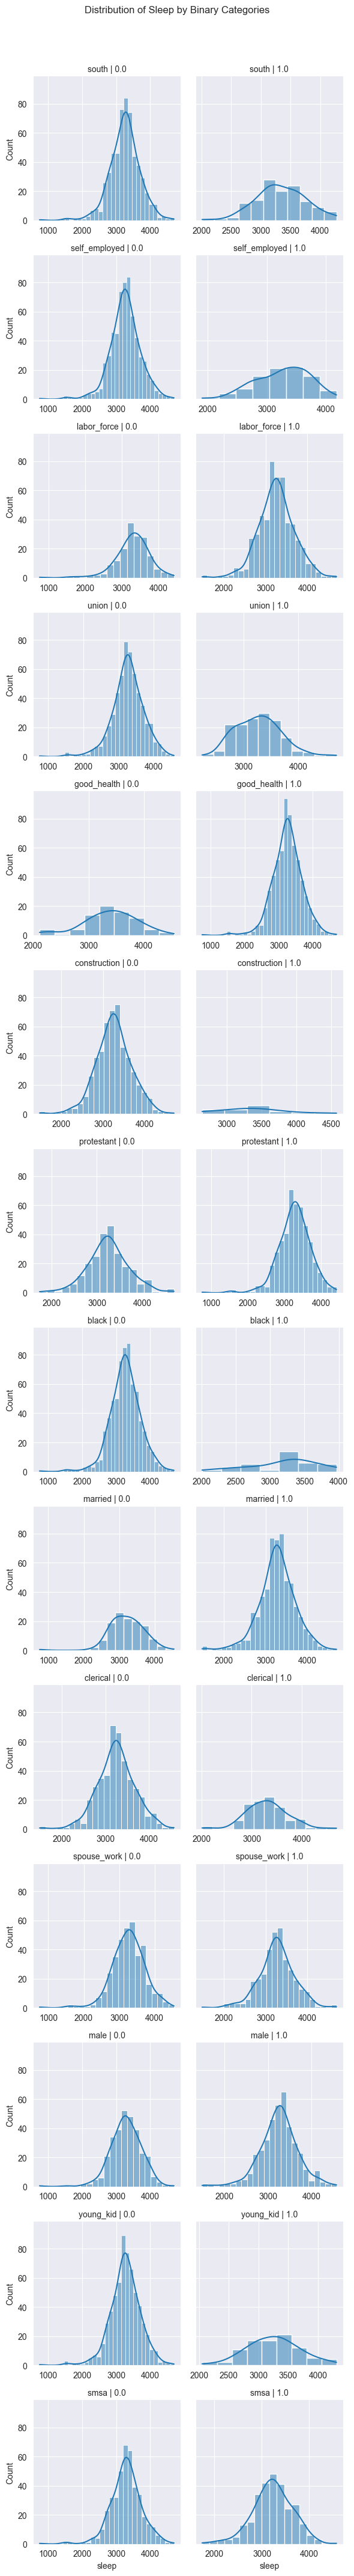

In [230]:
df_melted = df.melt(
    id_vars=["sleep"],
    value_vars=binary_columns,
    var_name="category_value",
    value_name="category_name"
)

g = sns.FacetGrid(df_melted, col="category_name", row="category_value", sharex=False)
g.map(sns.histplot, "sleep", kde=True)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.suptitle("Distribution of Sleep by Binary Categories", y=1.02)
plt.show()

### Regression Analysis

In [235]:
import statsmodels.api as sm

df_no_na = df_normalized.dropna(how="any")

X = df_no_na[['total_work', 'hour_wage']].copy()
y = df_no_na["sleep"]

# Step 2: Convert all columns to numeric (in case some are object types)
X = X.astype('float64')
y = y.astype('int64')

# Step 3: Add constant term
X = sm.add_constant(X)

# Step 4: Fit the model
model1 = sm.OLS(y, X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     31.02
Date:                Sat, 31 May 2025   Prob (F-statistic):           1.82e-13
Time:                        17:29:01   Log-Likelihood:                -3952.0
No. Observations:                 532   AIC:                             7910.
Df Residuals:                     529   BIC:                             7923.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3583.3359     46.835     76.510      0.0

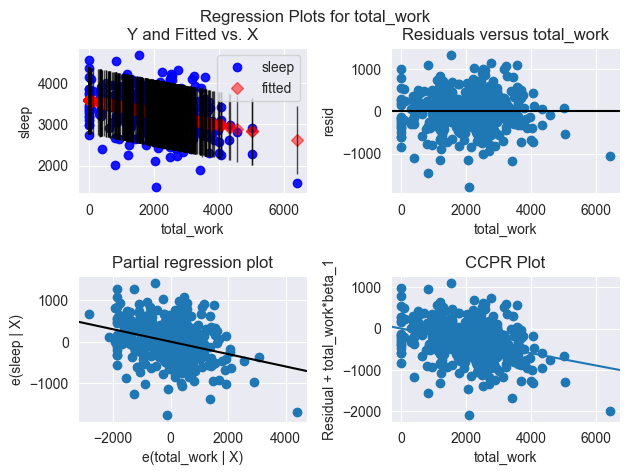

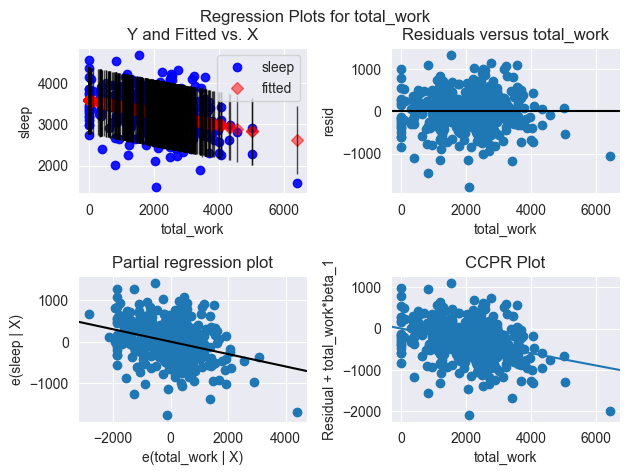

In [237]:
sm.graphics.plot_regress_exog(model1, "total_work")

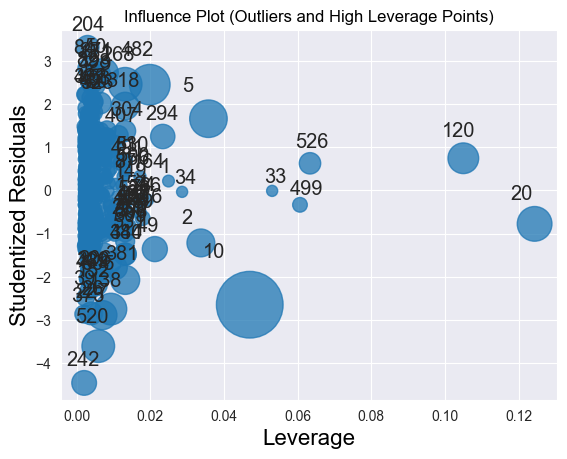

In [241]:
sm.graphics.influence_plot(model1, criterion="cooks")
plt.title("Influence Plot (Outliers and High Leverage Points)")
plt.show()

In [244]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.75, random_state=42)

In [250]:
import statsmodels.formula.api as smf
df_filled = df_normalized.fillna(0)
model2 = smf.ols('sleep ~ total_work + hour_wage', data=df_filled)
result2 = model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sleep   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     40.49
Date:                Sat, 31 May 2025   Prob (F-statistic):           2.27e-17
Time:                        18:11:40   Log-Likelihood:                -5267.1
No. Observations:                 706   AIC:                         1.054e+04
Df Residuals:                     703   BIC:                         1.055e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3587.1820     39.752     90.238      0.000    3509.134    3665.230
total_work    -0.1504      0.017     -8.788      0.000      -0.184      -0.117
hour_wage     -0.4157      4.129     -0.101      0.920      -8.523       7.691
==============================================================================
Omnibus:                       68.971   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.184
Skew:                          -0.485   Prob(JB):                     1.12e-42
Kurtosis:                       5.372   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [253]:
mse_result1 = model1.mse_resid
res_result1 = np.sqrt(mse_result1)
print("The residual standard error for model 1 is:", np.round(res_result1, 3))

mse_result2 = result2.mse_resid
res_result2 = np.sqrt(mse_result2)
print("The residual standard error for model 2 is:", np.round(res_result2, 3))

The residual standard error for model 1 is: 408.493
The residual standard error for model 2 is: 421.432


In [255]:
X_test = test[['total_work', 'hour_wage']].copy()
X_test = X_test.fillna(0)
X_test = sm.add_constant(X_test)

y_test = test['sleep']

y_pred = result2.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 428.21
